# Using OpenSTL in your own project

In this notebook, we will provide a comprehensive guide on how to use OpenSTL for your own project. 

Firstly, we will process video data into `.npy` format for easier storage and access. Next, we will demonstrate how to utilize custom data within OpenSTL. Subsequently, we will use OpenSTL to train and evaluate models. Finally, we will visualize predicted frames and generate `.gif` images or videos. 

- [1. Preprocess your data](#1-process-your-data)
    - [1.1 Save the dataset](#11-save-the-dataset)
    - [1.2 Load the dataset and visualize an example](#12-load-the-dataset-and-visualize-an-example)

- [2. Utilize cumtom data](#2-utilize-cumtom-data)
    - [2.1 Define the dataset](#21-define-the-dataset)
    - [2.2 Get the dataloaders](#22-get-the-dataloaders)

- [3. Train and evaluate](#3-train-and-evaluate)
    - [3.1 Define the custom configs](#31-define-the-custom-configs)
    - [3.2 Setup the experiment](#32-setup-the-experiment)
    - [3.3 Start training and evaluation](#33)

- [4. Visualization](#4-visualization)
    - [4.1 Visualize in a line](#41-visualize-in-a-line)
    - [4.2 Generate a GIF](#42-generate-a-gif)

Here we go!

## 1. Process your data

Assume you possess a collection of videos and have already sorted them into the `train/`, `val/`, and `test/` directories. The subsequent step involves transforming these videos into a `.pkl` file for further manipulations.

The existing file hierarchy is as follows:

- custom_usage.ipynb
- train
  - train_example1.avi
  - train_example2.avi
- val
  - val_example1.avi
  - val_example2.avi
- test
  - test_example.avi

It's crucial to note that the above example represents a simplified scenario where we've used `.avi` videos for illustrative purposes. However, in a real-world application, you are free to employ videos in various other formats.

We utilize several videos from the KTH dataset as examples. Although the original KTH dataset consists of single-channel grayscale videos, we save them as three-channel RGB videos to accommodate a broader range of use cases.

### 1.1 Save the dataset

Here, we default to uniformly sampling several frames from the given video data. The number of observed frames and future frames are two hyperparameters (`pre_seq_length`, `aft_seq_length`) that are set in advance. You can also choose to sample the video in other ways and save the data.

#### hyperparameters

`pre_seq_length`: the number of given frames

`aft_seq_length`: the number of frames to predict

In [1]:
# pre_seq_length = 12
# aft_seq_length = 12

In [2]:
# import cv2
# import numpy as np
# import os
# import pickle

# dataset = {}
# folders = ['train', 'val', 'test']
# for folder in folders:
#     data_x = []
#     data_y = [] 
#     for file in os.listdir(folder):
#         file= os.path.join(folder, file)
#         seq = np.load(file)
#         data_x.append(seq[0:12])
#         data_y.append(seq[12:24])   
#     dataset['X_' + folder], dataset['Y_' + folder] = np.array(data_x), np.array(data_y)

# # save as a pkl file
# with open('dataset.pkl', 'wb') as f:
#     pickle.dump(dataset, f)

In [3]:
# print(dataset["X_train"].shape)

### 1.2 Load the dataset and visualize an example

In [4]:
import pickle
import cv2
import numpy as np
import os

pre_seq_length = 12
aft_seq_length = 12

# load the dataset
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

train_x, train_y = dataset['X_train'], dataset['Y_train']
print(train_x.shape)
# the shape is B x T x C x H x W
# B: the number of samples
# T: the number of frames in each sample
# C, H, W: the height, width, channel of each frame

(899, 12, 1, 144, 144)


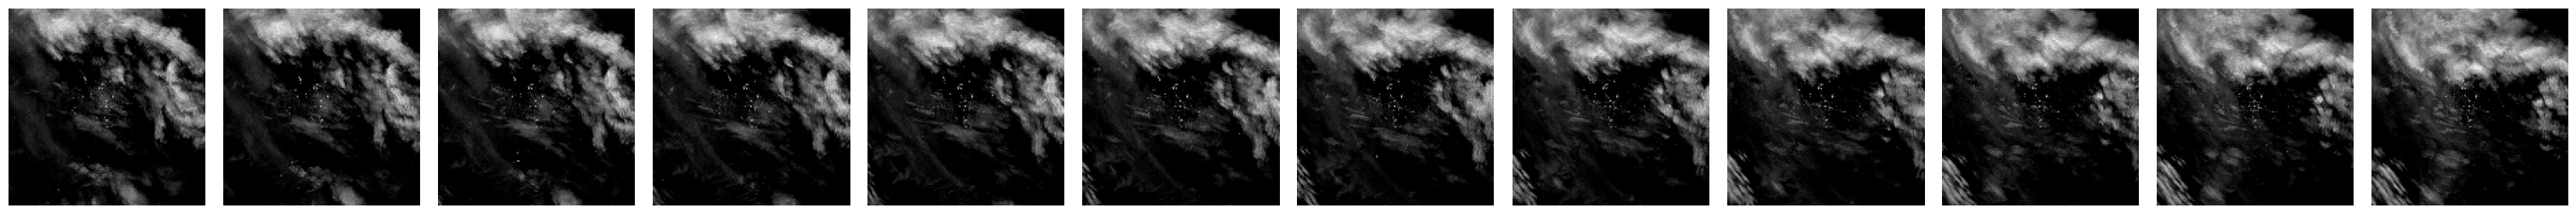

In [5]:
from openstl.utils import show_video_line

# show the given frames from an example
example_idx = 0
show_video_line(train_x[example_idx], ncols=pre_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

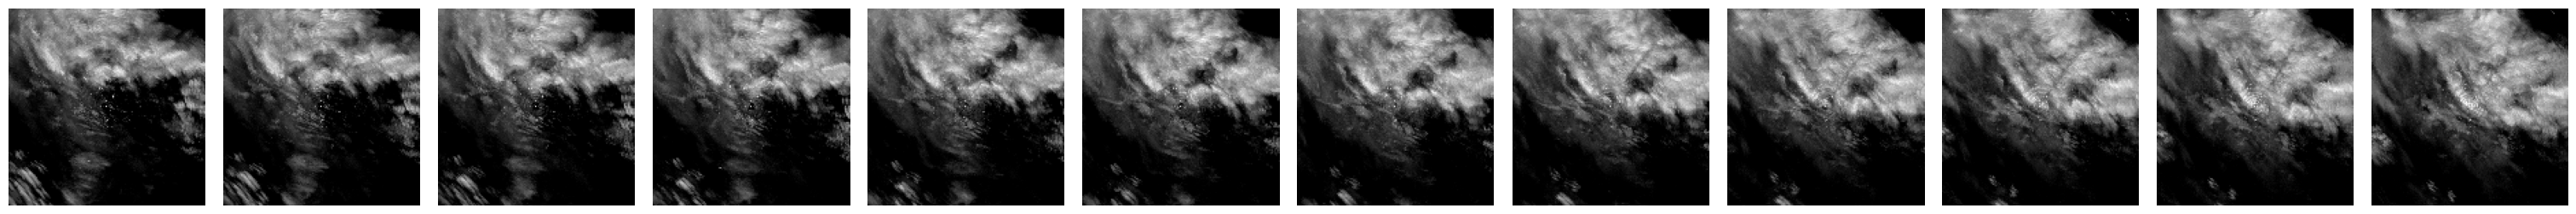

In [6]:
# show the future frames from an example
example_idx = 0
show_video_line(train_y[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

## 2. Utilize cumtom data

### 2.1 Define the dataset

We first define the `CustomDataset` to use the provided dataset. 

For real video prediction, to facilitate model optimization, we strongly recommend users to use frames represented as `float32` with values in the range of $[0, 1]$, rather than frames represented as `uint8` with values in the range of $[0, 255]$. For other types of data, we also provide the option to `normalize` in the `CustomDataset`.

In [7]:
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels

### 2.2 Get the dataloaders

Now we can get the dataloaders by using the collected dataset and the defined `CustomDataset`.

#### hyperparameters

`batch_size`: the size of a batch

In [8]:
batch_size = 4

In [9]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset['X_train'], dataset[
    'X_val'], dataset['X_test'], dataset['Y_train'], dataset['Y_val'], dataset['Y_test']

train_set = CustomDataset(X=X_train, Y=Y_train)
val_set = CustomDataset(X=X_val, Y=Y_val)
test_set = CustomDataset(X=X_test, Y=Y_test)

In [10]:
dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

## 3. Train and evaluate

### 3.1 Define the custom configs

We first define the training configuration, which includes several important hyperparameters for training.

Here, we set `epoch = 3` as an example for simple training. The actual value of epoch in your project depends on the complexity of your dataset. Generally, a good starting point is `epoch = 100`.

Next, we define the model configuration to customize a spatio-temporal predictive learning model. For MetaVP models, the key hyperparameters are: `N_S`, `N_T`, `hid_S`, `hid_T`, and `model_type`. Users have the option to either use a config file or directly set these hyperparameters.

If a config file is preferred, the user can simply include a `config_file` key with the path to the config file in the `custom_model_config` below. Otherwise, the user can directly specify these hyperparameters in the `custom_model_config`.

In [11]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    # 'val_batch_size': 1,
    'epoch': 10,
    'lr': 0.001,   
    'metrics': ['mse', 'mae'],   # ['mae', 'mse', 'rmse', 'ssim', 'psnr', 'snr', 'lpips']
    'drop_path': 0,
    'sched': 'onecycle',

    "num_workers": 	8,
    # "warmup_epoch": 	5,
    # "warmup_lr": 	1e-06,
    
    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [12, 1, 144, 144],
}

custom_model_config = {
    # For MetaVP models, the most important hyperparameters are: 
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'simVP', #SimVP #PredRNNv2 
    # Users can either using a config file or directly set these hyperparameters 
    # 'config_file': 'configs/custom/example_model.py', there are example for all models parameters in /configs
    'loss': 'msceloss',
    # Here, we directly set these parameters
    'model_type': 'swin', # gSTA #swin 
    'N_S': 4,
    'N_T': 8, #8
    'hid_S': 64, #64
    'hid_T': 512, #512
    'spatio_kernel_enc': 3,
    'spatio_kernel_dec': 3,
    
    # #PredRNNv2
    # 'num_hidden': '128,128,128,128',
    # 'filter_size': 5,
    # 'stride': 1,
    # 'patch_size': 4,
    # 'layer_norm': 0,
    # 'decouple_beta': 0.1,
    # 'reverse_scheduled_sampling': 1,
    # 'r_sampling_step_1': 25000,
    # 'r_sampling_step_2': 50000,
    # 'r_exp_alpha': 5000,
    # # scheduled sampling
    # 'scheduled_sampling': 1,
    # 'sampling_stop_iter': 50000,
    # 'sampling_start_value': 1.0,
    # 'sampling_changing_rate': 0.00002
    
}

### 3.2 Setup the experiment

We retrieve the default hyperparameters by utilizing `create_parser` and update those hyperparameters that are defined in `custom_training_config` and `custom_model_config`. 

By utilizing `BaseExperiment`, we ensure that everything is prepared, including dataloader setup and model initialization.

In [12]:
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser

args = create_parser().parse_args([])
config = args.__dict__

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)
# fulfill with default values
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test))

Use non-distributed mode with GPU: cuda:0
Environment info:
------------------------------------------------------------
sys.platform: win32
Python: 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:16:33) [MSC v.1929 64 bit (AMD64)]
CUDA available: True
CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.3
NVCC: Not Available
GPU 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU
GCC: <built-in method strip of str object at 0x0000028762353CF0>
PyTorch: 2.1.0+cu118
PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=c

C:\Users\Aleja\miniconda3\envs\OpenSTL\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



device: 	cuda	
dist: 	False	
display_step: 	10	
res_dir: 	work_dirs	
ex_name: 	custom_exp	
use_gpu: 	True	
fp16: 	False	
torchscript: 	False	
seed: 	42	
diff_seed: 	False	
fps: 	False	
empty_cache: 	True	
find_unused_parameters: 	False	
broadcast_buffers: 	True	
resume_from: 	None	
auto_resume: 	False	
test: 	False	
inference: 	False	
deterministic: 	False	
launcher: 	none	
local_rank: 	0	
port: 	29500	
batch_size: 	4	
val_batch_size: 	16	
num_workers: 	8	
data_root: 	./data	
dataname: 	custom	
pre_seq_length: 	12	
aft_seq_length: 	12	
total_length: 	24	
use_augment: 	False	
use_prefetcher: 	False	
drop_last: 	False	
method: 	simvp	
config_file: 	configs/mmnist/simvp/SimVP_gSTA.py	
model_type: 	swin	
drop: 	0.0	
drop_path: 	0	
overwrite: 	False	
loss: 	msceloss	
epoch: 	10	
log_step: 	1	
opt: 	adam	
opt_eps: 	None	
opt_betas: 	None	
momentum: 	0.9	
weight_decay: 	0.0	
clip_grad: 	None	
clip_mode: 	norm	
early_stop_epoch: 	-1	
no_display_method_info: 	False	
sched: 	onecycle	
lr: 	0.00

### 3.3 Start training and evaluation

With everything in place, we are now ready to start training and evaluation. 

Here we go!

In [ ]:
print('>'*35 + ' training ' + '<'*35)
exp.train()

print('>'*35 + ' testing  ' + '<'*35)
exp.test()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


  0%|                                                                                          | 0/225 [00:00<?, ?it/s]

## Visualization

By employing the `show_video_line` and `show_video_gif_multiple` functions provided by `OpenSTL`, we can visualize the input, ground truth, and predicted frames, as well as generate corresponding GIFs.

### 4.1 Visualize in a line

In [ ]:
import numpy as np
from openstl.utils import show_video_line

# show the given frames from an example
inputs = np.load('./work_dirs/custom_exp/saved/inputs.npy')
preds = np.load('./work_dirs/custom_exp/saved/preds.npy')
trues = np.load('./work_dirs/custom_exp/saved/trues.npy')

example_idx = 0
show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

In [ ]:

show_video_line(preds[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

### 4.2 Generate a GIF

In [ ]:
from openstl.utils import show_video_gif_multiple


show_video_gif_multiple(inputs[example_idx], trues[example_idx], preds[example_idx], use_rgb=True, out_path='example.gif')

In [ ]:
print(preds.shape)
img_idx = 83
preds_ = preds * 70
bins = np.array([0., 10., 15., 20., 25., 30., 35., 40., 45., 70.])
preds_ = np.digitize(preds_,bins, right = False)


trues_ = trues * 70
for i in range(12):
    plt.imshow(preds_[img_idx][i][0])
    
    plt.colorbar()
    plt.show()

    plt.imshow(preds[img_idx][i][0])
    plt.show()
    plt.imshow(trues[img_idx][i][0])
    plt.show()
    
    # fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # ax1.imshow(preds_[img_idx][i][0])
    # ax2.imshow(trues_[img_idx][i][0])
    # plt.colorbar(preds_[img_idx][i][0], ax = ax1)